In [228]:
import pandas as pd
import numpy as np

pd.set_option('display.float_format', '{:.2f}'.format) 

In [229]:
df = pd.read_csv('May_18_2019.csv')

In [230]:
df.rename(columns=lambda x: x.strip(), inplace=True)
df.head(50)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,00:00:00,REGULAR,7053483,2390505
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,04:00:00,REGULAR,7053511,2390508
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,08:00:00,REGULAR,7053534,2390536
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,12:00:00,REGULAR,7053618,2390596
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,16:00:00,REGULAR,7053841,2390655
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,20:00:00,REGULAR,7054133,2390702
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/12/2019,00:00:00,REGULAR,7054291,2390726
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/12/2019,04:00:00,REGULAR,7054308,2390730
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/12/2019,08:00:00,REGULAR,7054318,2390747
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/12/2019,12:00:00,REGULAR,7054368,2390812


In [247]:
df[(df.STATION == 'BAYCHESTER AV') & (df.UNIT == 'R292')].tail(50)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
206502,R729,R292,00-00-01,BAYCHESTER AV,5,IRT,05/16/2019,17:00:00,REGULAR,7371029,650235
206503,R729,R292,00-00-01,BAYCHESTER AV,5,IRT,05/16/2019,21:00:00,REGULAR,7371229,650282
206504,R729,R292,00-00-01,BAYCHESTER AV,5,IRT,05/17/2019,01:00:00,REGULAR,7371277,650303
206505,R729,R292,00-00-01,BAYCHESTER AV,5,IRT,05/17/2019,05:00:00,REGULAR,7371311,650315
206506,R729,R292,00-00-01,BAYCHESTER AV,5,IRT,05/17/2019,09:00:00,REGULAR,7372070,650335
206507,R729,R292,00-00-01,BAYCHESTER AV,5,IRT,05/17/2019,13:00:00,REGULAR,7372352,650351
206508,R729,R292,00-00-01,BAYCHESTER AV,5,IRT,05/17/2019,17:00:00,REGULAR,7372730,650391
206509,R729,R292,00-00-01,BAYCHESTER AV,5,IRT,05/17/2019,21:00:00,REGULAR,7372914,650463
206510,R729,R292,00-00-02,BAYCHESTER AV,5,IRT,05/11/2019,01:00:00,REGULAR,8118159,689229
206511,R729,R292,00-00-02,BAYCHESTER AV,5,IRT,05/11/2019,05:00:00,REGULAR,8118165,689240


In [231]:
def outlier_check(df, station, scp, n=50):
    return df[(df.STATION == station) & (df.SCP == scp)].head(n)

outlier_check(df,'3 AV-149 ST', '00-00-03', 30)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
175572,R311,R053,00-00-03,3 AV-149 ST,25,IRT,05/11/2019,00:00:00,REGULAR,1929035689,670749980
175573,R311,R053,00-00-03,3 AV-149 ST,25,IRT,05/11/2019,04:00:00,REGULAR,1929035628,670749850
175574,R311,R053,00-00-03,3 AV-149 ST,25,IRT,05/11/2019,08:00:00,REGULAR,1929035554,670749764
175575,R311,R053,00-00-03,3 AV-149 ST,25,IRT,05/11/2019,12:00:00,REGULAR,1929035396,670749572
175576,R311,R053,00-00-03,3 AV-149 ST,25,IRT,05/11/2019,16:00:00,REGULAR,1929035098,670749343
175577,R311,R053,00-00-03,3 AV-149 ST,25,IRT,05/11/2019,20:00:00,REGULAR,1929034901,670749009
175578,R311,R053,00-00-03,3 AV-149 ST,25,IRT,05/12/2019,00:00:00,REGULAR,1929034756,670748758
175579,R311,R053,00-00-03,3 AV-149 ST,25,IRT,05/12/2019,04:00:00,REGULAR,1929034711,670748662
175580,R311,R053,00-00-03,3 AV-149 ST,25,IRT,05/12/2019,08:00:00,REGULAR,1929034675,670748616
175581,R311,R053,00-00-03,3 AV-149 ST,25,IRT,05/12/2019,12:00:00,REGULAR,1929034598,670748497


In [163]:
outlier_check(df,'42 ST-PORT AUTH', '01-00-01',50)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
51263,N060,R010,01-00-01,42 ST-PORT AUTH,ACENGRS1237W,IND,01/04/2020,01:00:00,REGULAR,14969295,13599505
51264,N060,R010,01-00-01,42 ST-PORT AUTH,ACENGRS1237W,IND,01/04/2020,05:00:00,REGULAR,14969364,13599532
51265,N060,R010,01-00-01,42 ST-PORT AUTH,ACENGRS1237W,IND,01/04/2020,09:00:00,REGULAR,14969413,13599706
51266,N060,R010,01-00-01,42 ST-PORT AUTH,ACENGRS1237W,IND,01/04/2020,13:00:00,REGULAR,14969591,13600145
51267,N060,R010,01-00-01,42 ST-PORT AUTH,ACENGRS1237W,IND,01/04/2020,17:00:00,REGULAR,14969929,13600809
51268,N060,R010,01-00-01,42 ST-PORT AUTH,ACENGRS1237W,IND,01/04/2020,21:00:00,REGULAR,14970239,13601486
51269,N060,R010,01-00-01,42 ST-PORT AUTH,ACENGRS1237W,IND,01/05/2020,01:00:00,REGULAR,14970830,13601810
51270,N060,R010,01-00-01,42 ST-PORT AUTH,ACENGRS1237W,IND,01/05/2020,05:00:00,REGULAR,14970900,13601839
51271,N060,R010,01-00-01,42 ST-PORT AUTH,ACENGRS1237W,IND,01/05/2020,09:00:00,REGULAR,14970935,13601959
51272,N060,R010,01-00-01,42 ST-PORT AUTH,ACENGRS1237W,IND,01/05/2020,13:00:00,REGULAR,14971058,13602347


In [232]:
outlier_check(df,'FLATBUSH AV-B.C', '01-00-01', 20)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
205670,R646,R110,01-00-01,FLATBUSH AV-B.C,25,IRT,05/11/2019,01:00:00,REGULAR,1506959639,1314083374
205671,R646,R110,01-00-01,FLATBUSH AV-B.C,25,IRT,05/11/2019,05:00:00,REGULAR,1506959632,1314083345
205672,R646,R110,01-00-01,FLATBUSH AV-B.C,25,IRT,05/11/2019,09:00:00,REGULAR,1506959535,1314083318
205673,R646,R110,01-00-01,FLATBUSH AV-B.C,25,IRT,05/11/2019,13:00:00,REGULAR,1506959383,1314083259
205674,R646,R110,01-00-01,FLATBUSH AV-B.C,25,IRT,05/11/2019,17:00:00,REGULAR,1506959192,1314083134
205675,R646,R110,01-00-01,FLATBUSH AV-B.C,25,IRT,05/11/2019,21:00:00,REGULAR,1506959068,1314083017
205676,R646,R110,01-00-01,FLATBUSH AV-B.C,25,IRT,05/12/2019,01:00:00,REGULAR,1506959025,1314082954
205677,R646,R110,01-00-01,FLATBUSH AV-B.C,25,IRT,05/12/2019,05:00:00,REGULAR,1506959016,1314082939
205678,R646,R110,01-00-01,FLATBUSH AV-B.C,25,IRT,05/12/2019,09:00:00,REGULAR,1506958970,1314082921
205679,R646,R110,01-00-01,FLATBUSH AV-B.C,25,IRT,05/12/2019,13:00:00,REGULAR,1506958877,1314082876


In [233]:
outlier_check(df,'34 ST-HERALD SQ', '00-05-04', 25)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
98906,N506,R022,00-05-04,34 ST-HERALD SQ,BDFMNQRW,IND,05/11/2019,00:00:00,REGULAR,1255159545,2048360755
98907,N506,R022,00-05-04,34 ST-HERALD SQ,BDFMNQRW,IND,05/11/2019,04:00:00,REGULAR,1255159419,2048360837
98908,N506,R022,00-05-04,34 ST-HERALD SQ,BDFMNQRW,IND,05/11/2019,08:00:00,REGULAR,1255159324,2048360952
98909,N506,R022,00-05-04,34 ST-HERALD SQ,BDFMNQRW,IND,05/11/2019,12:00:00,REGULAR,1255158810,2048361357
98910,N506,R022,00-05-04,34 ST-HERALD SQ,BDFMNQRW,IND,05/11/2019,16:00:00,REGULAR,1255157762,2048362056
98911,N506,R022,00-05-04,34 ST-HERALD SQ,BDFMNQRW,IND,05/11/2019,20:00:00,REGULAR,1255156618,2048362726
98912,N506,R022,00-05-04,34 ST-HERALD SQ,BDFMNQRW,IND,05/12/2019,00:00:00,REGULAR,1255155987,2048363061
98913,N506,R022,00-05-04,34 ST-HERALD SQ,BDFMNQRW,IND,05/12/2019,04:00:00,REGULAR,1255155878,2048363122
98914,N506,R022,00-05-04,34 ST-HERALD SQ,BDFMNQRW,IND,05/12/2019,08:00:00,REGULAR,1255155823,2048363200
98915,N506,R022,00-05-04,34 ST-HERALD SQ,BDFMNQRW,IND,05/12/2019,12:00:00,REGULAR,1255155564,2048363576


In [234]:
outlier_check(df,'34 ST-HERALD SQ', '00-05-03', 25)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
98864,N506,R022,00-05-03,34 ST-HERALD SQ,BDFMNQRW,IND,05/11/2019,00:00:00,REGULAR,27891441,12270193
98865,N506,R022,00-05-03,34 ST-HERALD SQ,BDFMNQRW,IND,05/11/2019,04:00:00,REGULAR,27891574,12270237
98866,N506,R022,00-05-03,34 ST-HERALD SQ,BDFMNQRW,IND,05/11/2019,08:00:00,REGULAR,27891665,12270307
98867,N506,R022,00-05-03,34 ST-HERALD SQ,BDFMNQRW,IND,05/11/2019,12:00:00,REGULAR,27892094,12270574
98868,N506,R022,00-05-03,34 ST-HERALD SQ,BDFMNQRW,IND,05/11/2019,16:00:00,REGULAR,27892985,12270998
98869,N506,R022,00-05-03,34 ST-HERALD SQ,BDFMNQRW,IND,05/11/2019,20:00:00,REGULAR,27894033,12271387
98870,N506,R022,00-05-03,34 ST-HERALD SQ,BDFMNQRW,IND,05/12/2019,00:00:00,REGULAR,27894613,12271594
98871,N506,R022,00-05-03,34 ST-HERALD SQ,BDFMNQRW,IND,05/12/2019,04:00:00,REGULAR,27894717,12271625
98872,N506,R022,00-05-03,34 ST-HERALD SQ,BDFMNQRW,IND,05/12/2019,08:00:00,REGULAR,27894766,12271654
98873,N506,R022,00-05-03,34 ST-HERALD SQ,BDFMNQRW,IND,05/12/2019,12:00:00,REGULAR,27895022,12271805


In [236]:
# group data by station, scp, then unit, which allows us to look at the entries and exits for each individual
# turnstile.
turnstiles = df.groupby(['STATION','UNIT','SCP'])['ENTRIES', 'EXITS'].agg(np.ptp) # np.ptp is 'peak-to-peak' max - min

#df['Foot Traffic'] = (df['ENTRIES'] - df['ENTRIES'].shift(-1)).abs() + (df['EXITS'] - df['EXITS'].shift(-1)).abs()

#turnstiles.sort_values('ENTRIES', ascending=False).head(50)

turnstiles.loc['59 ST']


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


ENTRIES  EXITS
UNIT SCP                     
R050 00-00-00     6912  17279
     00-00-01     5100   6231
     00-00-02     2093   1514
     00-00-03      792   1152
     00-00-04      308   2332
     00-03-00     2986   6999
     00-03-01     4385  12117
     00-03-02     5778  11076
     00-06-00     7255   6110
     00-06-01    13286   5781
     00-06-02    18325   5478
     01-00-00     6165  25004
     01-00-01    13840   8158
     01-00-02    14107   7255
     01-00-03    12948   3377
     01-00-04    19110   2978
     01-06-00     5712   6504
     01-06-01     2889   2254
R051 00-00-00     7210   5354
     00-03-00     4539  10971
     00-03-01     2375  16256
     00-03-02     2115  15249
     00-03-03     3612  11129
     00-05-00     6823   7362
     00-05-01     8629   3299
     00-05-02     7672   1520
     01-00-00    20414   8840
     01-00-01    18541  10878
     01-00-02    12180  23019
     01-00-03     8146  18622
     01-06-00     2499   6442
     01-06-01      620   6512
     02-00-00     8791   2951
     02-00-01     7128   1768
     02-03-00     2895  11873
     02-03-01     7837  12785
     02-03-02     8025   9059
     02-03-03     7153   6599
     02-03-04     7762   3207
     02-03-05    11703    886
     02-03-06     8926    164
     02-05-00        0      0
     02-05-01        0      4
     02-06-00     8304    266
R212 00-00-00    15545   7359
     00-00-01    10219   6621
     00-00-02    11337   7043
     00-00-03    14240  10090
     01-00-00     5185   4400
     01-00-01     2526   1558
     01-00-02     3160   1623
     01-00-03     7870   1581

In [241]:
turnstiles.loc['BAYCHESTER AV']

ENTRIES      EXITS
UNIT SCP                            
R292 00-00-00        5534       2395
     00-00-01       10380       1041
     00-00-02  2055532570  167130205

In [237]:
turnstiles.groupby('STATION').sum()

,ENTRIES,EXITS
STATION,,
1 AV,104834,119600
103 ST,185275,134000
103 ST-CORONA,125801,92770
104 ST,27965,14491
110 ST,65870,58539
...,...,...
WOODLAWN,42325,9471
WORLD TRADE CTR,108162,87907
WTC-CORTLANDT,79139,62788


In [238]:
# this represents the stations with the most ENTRIES for the week of May 11 to May 17 INCLUDING outliers
turnstiles.groupby('STATION')['ENTRIES', 'EXITS'].sum().sort_values('ENTRIES', ascending=False).head(10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,ENTRIES,EXITS
STATION,,
BAYCHESTER AV,2055548484,167133641
183 ST,1437265592,350953847
219 ST,902455552,317587430
66 ST-LINCOLN,110885950,61292879
HOUSTON ST,68353514,17122899
TIMES SQ-42 ST,37575163,89800049
ROCKAWAY AV,10525527,5370845
DELANCEY/ESSEX,9037952,5138863
72 ST,7901737,16247846


In [239]:
turnstiles.groupby('STATION')['ENTRIES', 'EXITS'].sum().describe()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,ENTRIES,EXITS
count,377.00,377.00
mean,12431975.54,2874963.35
std,137084526.19,26371137.63
min,1297.00,0.00
25%,28549.00,17685.00
50%,54890.00,37389.00
75%,115310.00,88613.00
max,2055548484.00,350953847.00


In [212]:
# sets the boundaries for the outliers according to the 1.5 * IQR rule

upper = 115310.00 + 1.5*(115310.00 - 28549.00) 
lower = 28549.00 - 1.5*(115310.00 - 28549.00) 

# remove potential outliers
turnstiles = turnstiles[(turnstiles.ENTRIES < upper) & (turnstiles.ENTRIES > lower)]

# this represents the stations with the most ENTRIES and EXITS for the week of Jan 4 to Jan 10
(turnstiles.groupby('STATION')['ENTRIES', 'EXITS'].sum().sort_values('ENTRIES', ascending=False).head(10), 
 turnstiles.groupby('STATION')['ENTRIES', 'EXITS'].sum().sort_values('EXITS', ascending=False).head(10))


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if __name__ == '__main__':


(                 ENTRIES   EXITS
 STATION                         
 34 ST-PENN STA    893738  880097
 23 ST             632995  502929
 FULTON ST         531389  495020
 GRD CNTRL-42 ST   512171  767005
 TIMES SQ-42 ST    471699  500998
 86 ST             454105  499955
 42 ST-PORT AUTH   389537  394836
 CANAL ST          384383  337265
 59 ST             382995  346374
 125 ST            381914  348567,
                  ENTRIES   EXITS
 STATION                         
 34 ST-PENN STA    893738  880097
 GRD CNTRL-42 ST   512171  767005
 23 ST             632995  502929
 TIMES SQ-42 ST    471699  500998
 34 ST-HERALD SQ   334546  500342
 86 ST             454105  499955
 FULTON ST         531389  495020
 14 ST-UNION SQ    351061  443833
 42 ST-PORT AUTH   389537  394836
 47-50 STS ROCK    340655  360560)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


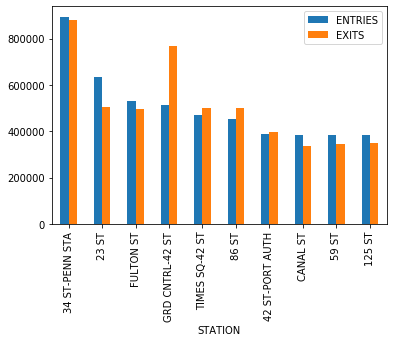

In [210]:
turnstiles.groupby('STATION')['ENTRIES', 'EXITS'].sum().sort_values('ENTRIES', ascending=False).head(10).plot(kind='bar')